In [2]:
import plotly_express as px
import pandas as pd
import numpy as np
import scipy
import scipy.stats as ss
import plotly.offline as py
import plotly.graph_objs as go
import re

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import zero_one_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set_style('darkgrid')

%matplotlib inline

import math

from scipy import stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\abrea\.julia\conda\3\envs\dashenv\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [2]:
#set the token for the mapbox
px.set_mapbox_access_token(open("mapbox_token.txt").read())

In [3]:
#read in the dataset
blm = pd.read_csv('police_killings_cleaned.csv', encoding='latin-1')

In [4]:
blm.head(2)

,name,age,gender,raceethnicity,month,day,year,streetaddress,city,state,...,share_hispanic,p_income,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college
0,A'donte Washington,17,Male,Black,February,23,2015,Clearview Ln,Millbrook,AL,...,5.6,28375,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510
1,Aaron Rutledge,28,Male,White,April,2,2015,300 block Iris Park Dr,Pineville,LA,...,0.5,14678,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402


In [5]:
blm.columns

Index(['name', 'age', 'gender', 'raceethnicity', 'month', 'day', 'year',
       'streetaddress', 'city', 'state', 'latitude', 'longitude', 'state_fp',
       'county_fp', 'tract_ce', 'geo_id', 'county_id', 'namelsad',
       'lawenforcementagency', 'cause', 'armed', 'pop', 'share_white',
       'share_black', 'share_hispanic', 'p_income', 'h_income',
       'county_income', 'comp_income', 'county_bucket', 'nat_bucket', 'pov',
       'urate', 'college'],
      dtype='object')

In [6]:
print (blm.isnull().sum())

name                     0
age                      0
gender                   0
raceethnicity            0
month                    0
day                      0
year                     0
streetaddress            4
city                     0
state                    0
latitude                 0
longitude                0
state_fp                 0
county_fp                0
tract_ce                 0
geo_id                   0
county_id                0
namelsad                 0
lawenforcementagency     0
cause                    0
armed                    0
pop                      0
share_white              0
share_black              0
share_hispanic           0
p_income                 0
h_income                 2
county_income            0
comp_income              2
county_bucket           27
nat_bucket               2
pov                      0
urate                    2
college                  2
dtype: int64


In [7]:
print (blm.isnull().sum().sum())

41


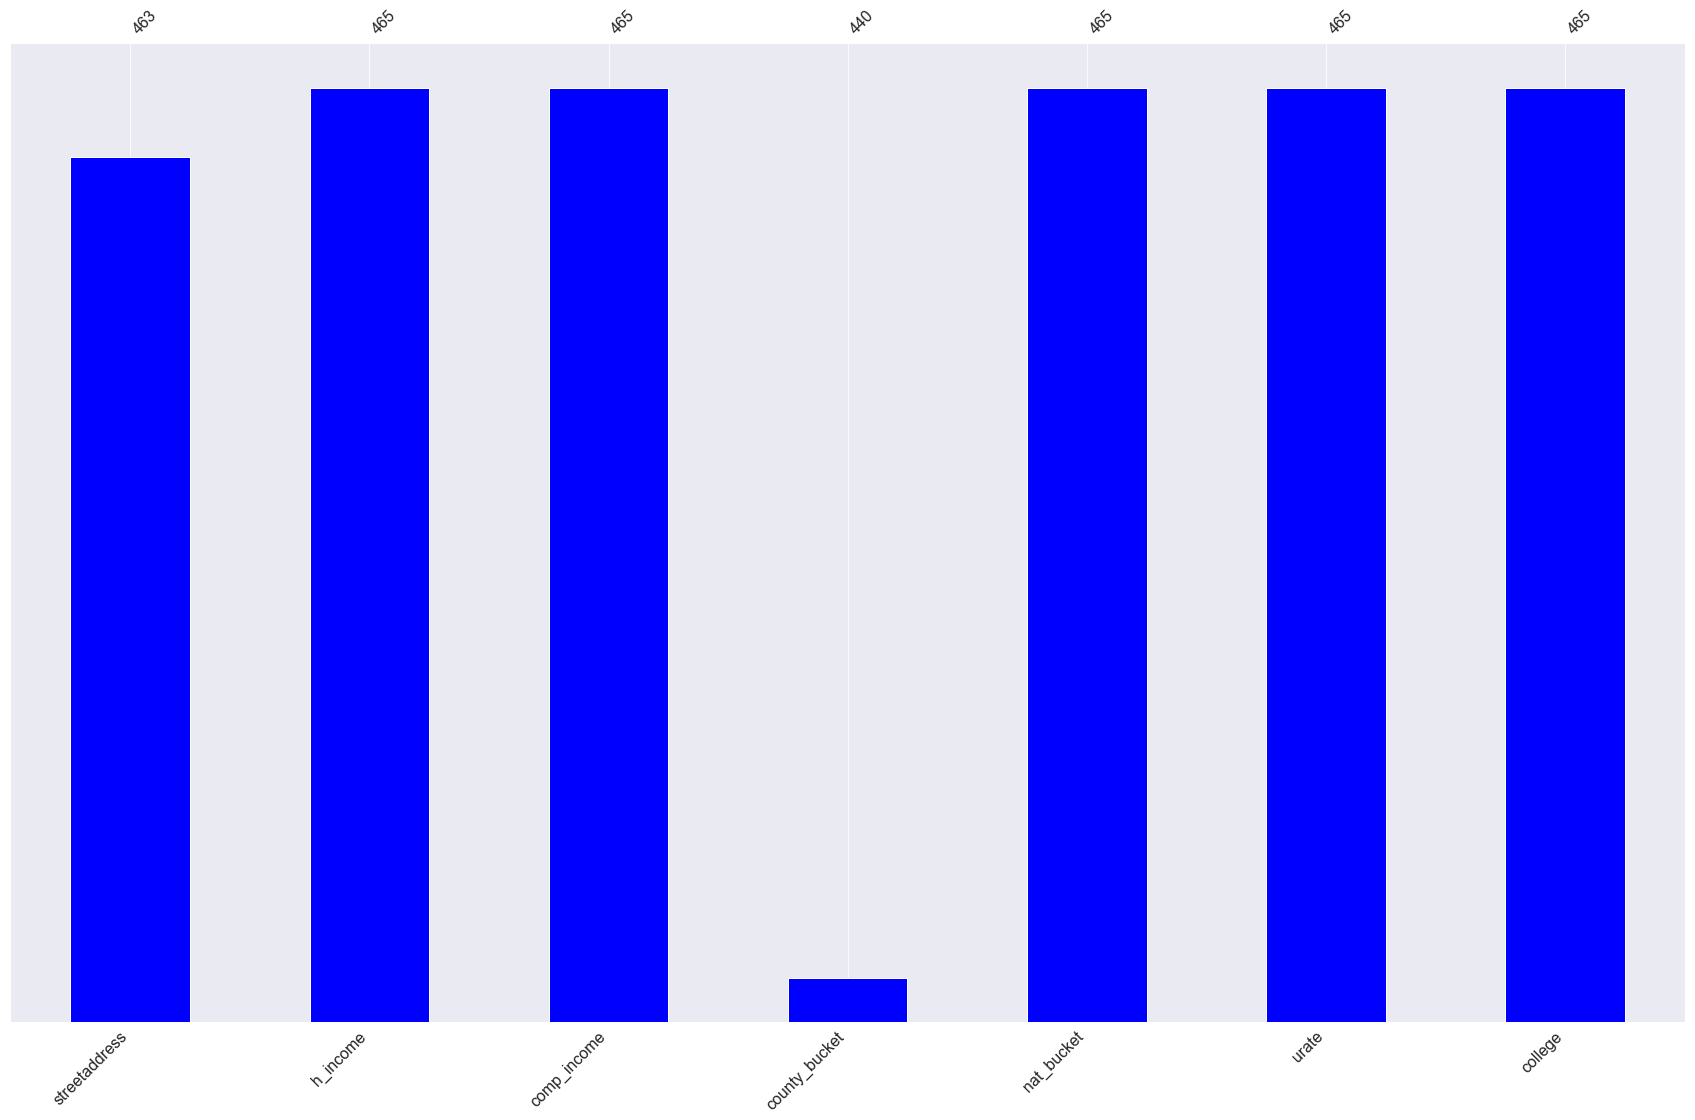

In [8]:
missingdata_df = blm.columns[blm.isnull().any()].tolist()
msno.bar(blm[missingdata_df], color="blue", log=True, figsize=(30,18))

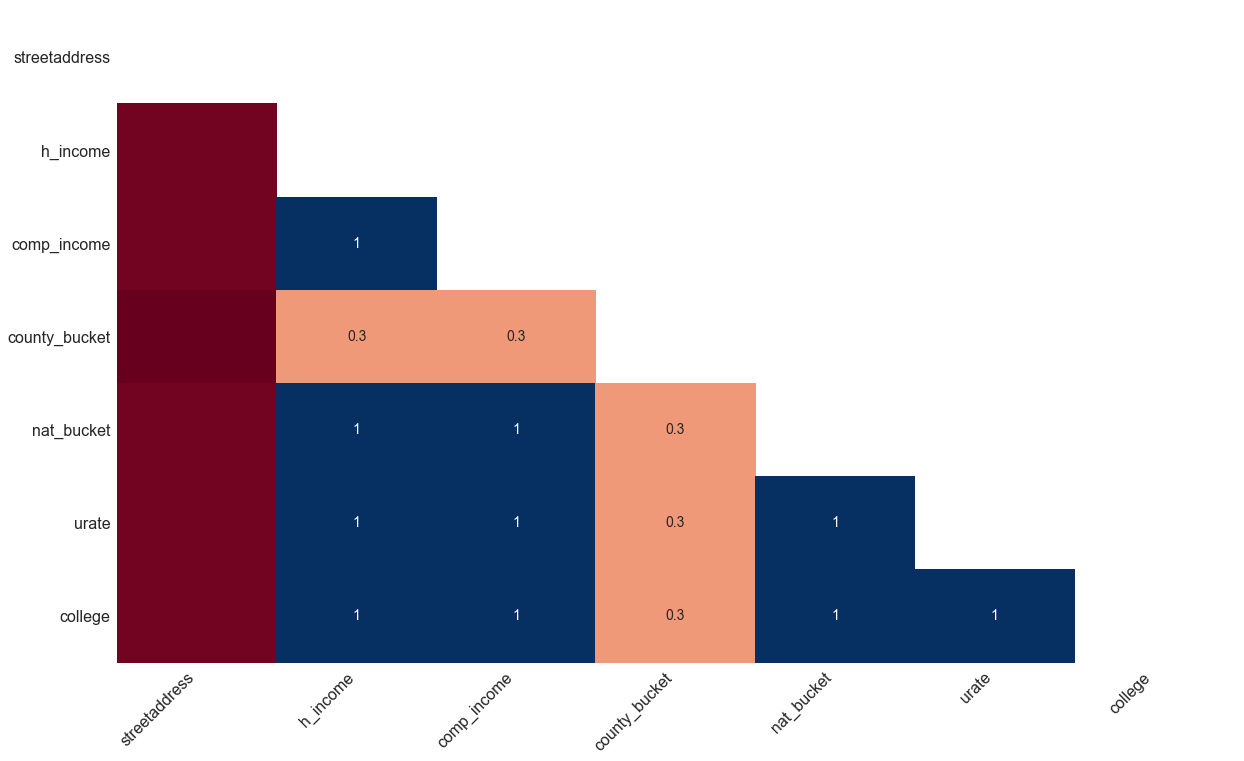

In [9]:
msno.heatmap(blm)

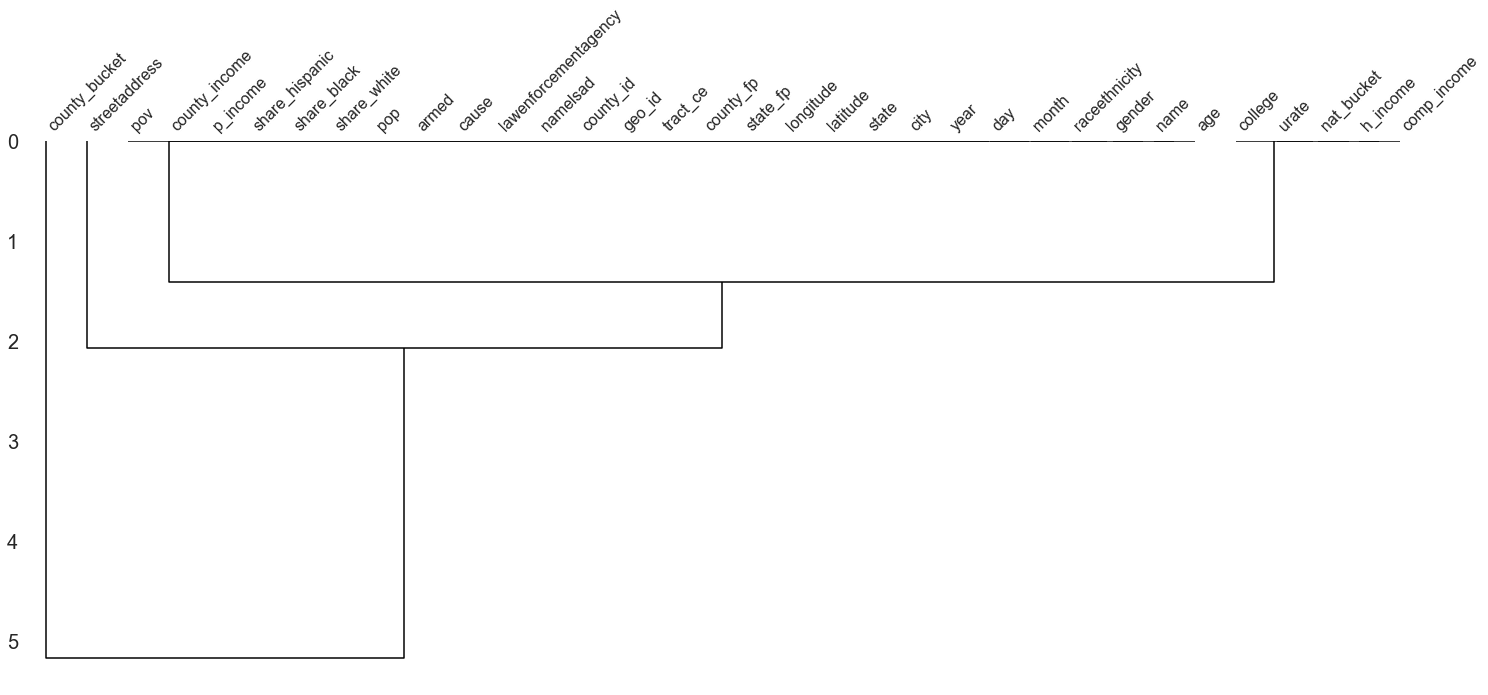

In [10]:
msno.dendrogram(blm)

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [12]:
cramers_v(blm['raceethnicity'],blm['armed'])

0.08470207876486861

In [13]:
cramers_v(blm['raceethnicity'],blm['age'])

0.09564357019935081

In [14]:
def correlation_ratio(categories, measurements):
    """
    Wikipedia: https://en.wikipedia.org/wiki/Correlation_ratio
    :param categories: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :param measurements: list / NumPy ndarray / Pandas Series
        A sequence of continuous measurements
    :return: float
        in the range of [0,1]
    """
    #categories = convert(categories, 'array')
    #measurements = convert(measurements, 'array')
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta


In [15]:
def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted

In [16]:
def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    """

    #dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=kwargs.get('figsize',None))
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'),mask=mask)
        plt.show()
    if return_results:
        return corr

In [11]:
cor_blm = blm[['age', 'gender', 'raceethnicity', 'state', 'cause', 'armed', 'pop', 'share_white',
       'share_black', 'share_hispanic', 'p_income', 'h_income',
       'county_income', 'comp_income', 'pov',
       'urate', 'college']]
cor_list = ['gender', 'state', 'cause', 'armed', 'raceethnicity']
cor_blm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 17 columns):
age               467 non-null int64
gender            467 non-null object
raceethnicity     467 non-null object
state             467 non-null object
cause             467 non-null object
armed             467 non-null object
pop               467 non-null int64
share_white       467 non-null object
share_black       467 non-null object
share_hispanic    467 non-null object
p_income          467 non-null object
h_income          465 non-null float64
county_income     467 non-null int64
comp_income       465 non-null float64
pov               467 non-null object
urate             465 non-null float64
college           465 non-null float64
dtypes: float64(4), int64(3), object(10)
memory usage: 62.1+ KB


In [6]:
convert = cor_blm[['share_white','share_black','share_hispanic','p_income','pov']]
convert = convert.apply(lambda col:pd.to_numeric(col, errors='coerce'))
convert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 5 columns):
share_white       465 non-null float64
share_black       465 non-null float64
share_hispanic    465 non-null float64
p_income          465 non-null float64
pov               465 non-null float64
dtypes: float64(5)
memory usage: 18.3 KB


In [7]:
cor_blm[['share_white','share_black','share_hispanic','p_income','pov']] = convert

C:\Users\abrea\.julia\conda\3\envs\dashenv\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [73]:
px.parallel_categories(cor_blm, color="share_black", color_continuous_scale=px.colors.sequential.Inferno)

In [57]:
px.box(cor_blm, x="gender", y="county_income", color="raceethnicity", notched=True)

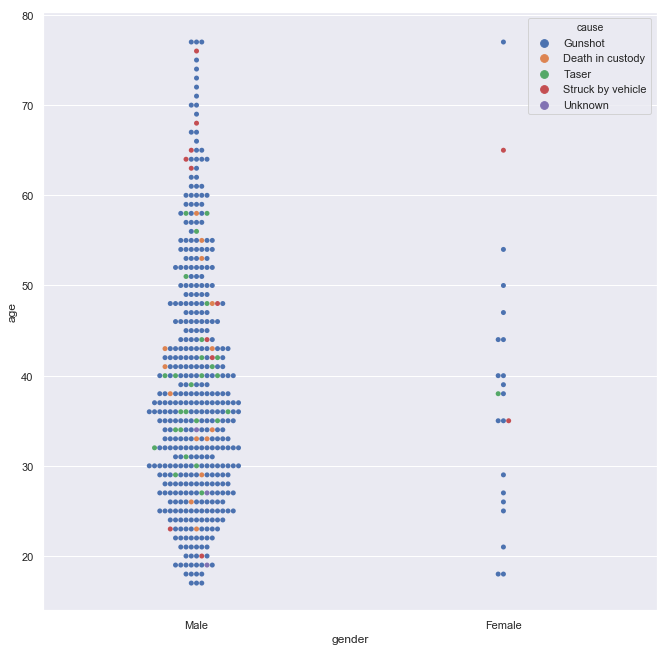

In [155]:
sns.set(rc={'figure.figsize':(11,11)})
ax = sns.swarmplot(x="gender",y="age",hue="cause",data=cor_blm)
ax

Text(0.5,1,'Age distribution, by raceethnicity')

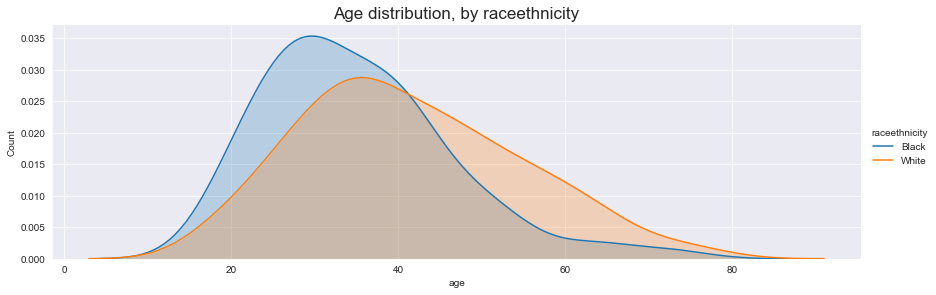

In [37]:
three_races = cor_blm.loc[(cor_blm["raceethnicity"] == "Black") | (cor_blm["raceethnicity"] == "White") | (cor_blm["raceethnicity"] == "Hispanic")]

g = sns.FacetGrid(data=three_races, hue="raceethnicity", aspect=3, height=4)
g.map(sns.kdeplot, "age", shade=True)
g.add_legend(title="raceethnicity")

g.set_ylabels("Count")
plt.title("Age distribution, by raceethnicity", fontsize=17)

In [31]:
# blm = blm.reset_index()

def ActualVsPopulation(df, pop, group):
    """Get actual per-group % vs population group % """
    d = {group: [], 'type': [], 'percent': []}
    tot_pop = float(sum(pop.values()))
    for g in df[group].dropna().unique(): #for each group

        # Actual percentages
        d[group].append(g)
        d['type'].append('Killings')
        d['percent'].append(100
                            * df[df[group]==g].index.value_counts()
                            / df.index.value_counts())

        # Percentages if statistic followed pop distribution
        d[group].append(g)
        d['type'].append('Population') #based on pop %age
        d['percent'].append(100*pop[g]/tot_pop)
        
    return pd.DataFrame(data=d)

#population
pop_s ={'AL': 4874747,
        'AK': 739795,
        'AZ': 7016270,
        'AR': 3004279,
        'CA': 39536653,
        'CO': 5607154,
        'CT': 3588184,
        'DE': 961939,
        'DC': 693972,
        'FL': 20984400,
        'GA': 10429379,
        'HI': 1427538,
        'ID': 1716943,
        'IL': 12802023,
        'IN': 6666818,
        'IA': 3145711,
        'KS': 2913123,
        'KY': 4454189,
        'LA': 4684333,
        'ME': 1335907,
        'MD': 6052177,
        'MA': 6859819,
        'MI': 9962311,
        'MN': 5576606,
        'MS': 2984100,
        'MO': 6113532,
        'MT': 1050493,
        'NE': 1920076,
        'NV': 2998039,
        'NH': 1342795,
        'NJ': 9005644,
        'NM': 2088070,
        'NY': 19849399,
        'NC': 10273419,
        'ND': 755393,
        'OH': 11658609,
        'OK': 3930864,
        'OR': 4142776,
        'PA': 12805537,
        'RI': 1059639,
        'SC': 5024369,
        'SD': 869666,
        'TN': 6715984,
        'TX': 28304596,
        'UT': 3101833,
        'VT': 623657,
        'VA': 8470020,
        'WA': 7405743,
        'WV': 1815857,
        'WI': 5795483,
        'WY': 579315}

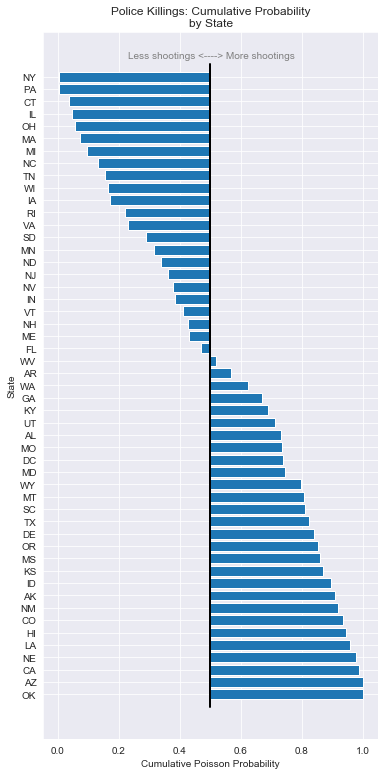

In [32]:
from scipy.stats import poisson 

# National average rate of police shootings per person
natl_rate = blm.shape[0]/sum(pop_s.values()) 

# Compute the cumulative Poisson distribution value for each state
cum_poisson_vals = [] #to store cumulative poisson values
for state in pop_s.keys():
    lam = natl_rate*pop_s[state] #shootings if matched avg (lambda)
    k = blm[blm.state==state].shape[0] #actual number of shootings
    cum_poisson_vals.append(poisson.cdf(k, lam))

# Plot cumulative Poisson distribution values
plt.figure(figsize=(6, 13))
EK = pd.DataFrame(data={'state': list(pop_s.keys()), 
                        'cum_poisson': cum_poisson_vals})
EK.sort_values('cum_poisson', inplace=True)
y = np.arange(len(EK.state))
plt.barh(y, EK.cum_poisson-0.5, left=0.5)
ax = plt.gca()
ax.set_yticks(y)
ax.set_yticklabels(EK.state)
ax.invert_yaxis()
plt.plot([0.5, 0.5], [y[0]-1, y[-1]+1], 'k', linewidth=2)
plt.title('Police Killings: Cumulative Probability\n' +
          'by State')
plt.ylabel('State')
plt.xlabel('Cumulative Poisson Probability')
plt.text(0.505, y[0]-1.5, 
         (r'Less shootings <--' + 
          r'--> More shootings'),
         horizontalalignment='center', color='gray')
plt.show()

In [29]:
px.box(blm, x="state", y="age")

In [48]:
px.histogram(blm, x="cause", y="cause", color="raceethnicity")

In [49]:
px.histogram(blm, x="state", y="state", color="raceethnicity")

In [51]:
px.histogram(blm, x="raceethnicity", y="raceethnicity", color="raceethnicity")

In [28]:
px.box(blm, x="cause", y="age", notched=True,color="raceethnicity")

In [68]:
cor_blm.gender.value_counts()

Male      445
Female     22
Name: gender, dtype: int64

In [90]:
cor_blm.raceethnicity.value_counts()

White                     236
Black                     135
Hispanic                   67
Unknown                    15
Asian/Pacific Islander     10
Native American             4
Name: raceethnicity, dtype: int64

In [97]:
males = cor_blm[(cor_blm['raceethnicity']=='Black') & (cor_blm['gender']=='Male')]
males.shape

(128, 17)

In [88]:
px.parallel_categories(cor_blm, color="age", color_continuous_scale=px.colors.sequential.Inferno)

In [101]:
%%capture
#gather features
features = "+".join(cor_blm.columns.difference(['state']))

# get y and X dataframes based on this regression:
y, X = dmatrices('raceethnicity ~' + features, cor_blm, return_type='dataframe')

In [102]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [103]:
vif.round(1)

,VIF Factor,features
0,1021.3,Intercept
1,119.9,armed[T.Firearm]
2,60.5,armed[T.Knife]
3,82.6,armed[T.No]
4,15.1,armed[T.Non-lethal firearm]
5,26.2,armed[T.Other]
6,8.1,armed[T.Unknown]
7,18.7,armed[T.Vehicle]
8,3.9,cause[T.Gunshot]
9,1.9,cause[T.Struck by vehicle]


In [104]:
cor_blm = cor_blm.drop(columns=['share_white',
       'share_black', 'share_hispanic', 'p_income', 'h_income','comp_income', 'pov',
       'urate', 'college'])
cor_blm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 8 columns):
age              467 non-null int64
gender           467 non-null object
raceethnicity    467 non-null object
state            467 non-null object
cause            467 non-null object
armed            467 non-null object
pop              467 non-null int64
county_income    467 non-null int64
dtypes: int64(3), object(5)
memory usage: 29.3+ KB


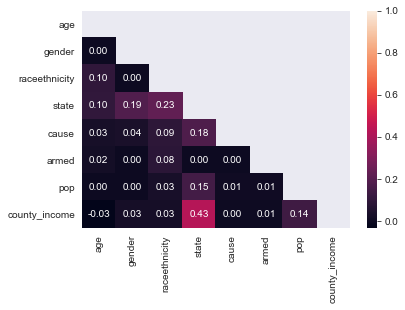

In [105]:
associations(cor_blm, nominal_columns=cor_list)

In [106]:
class design_hoverbox(object):
    
    
    def __init__(self, data, graph_object, vars_wanted = None, labs = None):
        """also need to set a default for
        the vars wanted...what if it is passed in as none!"""
        
        #if user passes in list of custom labels, ensure 
        #length of lables == length of variables specified by user. 
        if labs != None:
            len(vars_wanted) == len(labs)
        else:
            self.labs = labs
        
        #store a deep copy of the dataframe passed in:
        self.df = data.copy(deep=True)
        
        #add a reference index to the dataframe:
        self.df['ref_index'] = data.index
        
        #store a deep copy of the plotly graph object passed in
        self.graph = graph_object
        
        #store variables selected for inclusion in the hover box
        self.vars = vars_wanted
        
        #instantiate cat_name. If the user specified a group to color
        #or fill graph attributes by, this is set to cat_name
        self.cat_name = None
        
    
    def __get_group_inds__(self, group_i):
        """Sets the customdata for each group in the graph object to be
        the indexes that correspond to each row in that group"""
            
        #group_i_val is the name of the variable corresponding to the group_i
        group_i_val = re.split("=", self.graph.data[group_i].name)[1]

        #inds stores the indexes of the rows that correspond to each row in the ith group
        group_inds = self.df[self.df[self.cat_name] == group_i_val].ref_index

        #store a list of indexes corresponding to the rows that
        #belong to group_i in the customdata value for that group. 
        self.graph.data[group_i]["customdata"] = group_inds
        
        
    def __get_new_html__(self, point_index):
        """Returns a new htlm string for the hover box.
        uses the indexes created in get_custs to index the data frame
        and adds the information pertaining to that individual to the hover box"""

        #instantiate an empty string to hold html template
        to_ret = ''
        
        #for each data point in the group, create a new htmltemplate
        #that includes the variables specified by the user.
        for val_ind, val in enumerate(self.vars):
            
            new_value = self.df.iloc[[point_index]][self.vars[val_ind]][point_index]
            to_ret += '<br>' + self.vars[val_ind]+ ': ' + str(new_value)
            
        return to_ret
    
    def __change_hovertemplate__(self):
        """Changes the hovertemplate for each class.
        The hovertemplate for each data point is hard-coded in the customdata entry 
        for each group (stored in a list).
        The new hovertemplate calls customdata to retrieve the appropriate
        html string for each point."""
        
        for group_i, data_struct_i in enumerate(self.graph.data):
            data_struct_i.hovertemplate = "<b>%{customdata}"
            
             
    def new_hover_box(self):
        """Customizes a hover box object for a plotly graph object"""
        
        #if the graph has a grouped object (i,e., color = x),
        #call the get group inds function for each group
        if len(self.graph.data) > 1:
            self.cat_name = re.split("=", self.graph.data[1].name)[0]
            [self.__get_group_inds__(group_i) for group_i in range(len(self.graph.data))]
            
        else:
            #if the graph has no groups, set custom data to be a list 
            #of indexes for all the data points
            self.graph.data[0]["customdata"] = self.df.index

        #get new html passes in the names of the desired variables within the new 
        #html string 
        
        #Retrive a new html string for each data point,
        #which includes the variables selected by the user. 
        for group_i, data_struct_i in enumerate(self.graph.data):
            
            #change customdata entry in each group to be a list of
            #hovertemplates corresponding to each row in that group
            data_struct_i.customdata = [self.__get_new_html__(point_index)
                                       for point_index in data_struct_i.customdata]
        
        #change the html code on the hovertemplate 
        self.__change_hovertemplate__()

In [110]:
shooting_map = px.scatter_mapbox(blm, lat="latitude", lon="longitude", color = 'raceethnicity', 
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15
                                 ,hover_name = "raceethnicity", height = 600, width = 1100, zoom=2)

shooting_map.layout.title = go.layout.Title(text = "Map Quest",x=.35)

#adjusting the legend of the plot
shooting_map.layout.legend.font = {'color':"black",'family': 'Serif', 'size': 15}
shooting_map.layout.legend.bgcolor = 'white'#change the color of the box with this. 
shooting_map.layout.legend.bordercolor = 'black'
shooting_map.layout.legend.borderwidth = 2
shooting_map.layout.annotations = [dict(text = 'Ethnicity', x=1.15, y=1.05, showarrow = False,
                                        font = {'color':"black",'family': 'Serif', 'size': 20})]

new_box = design_hoverbox(data=blm, graph_object=shooting_map, vars_wanted=["gender","cause"])
call = new_box.new_hover_box()
shooting_map